## Data Exploratory

In this section, we will apply natural languages processes step to clean up the text string, identify data pattern, and extract out relevant features that have high correlation to user ratings.

In [1]:
import pickle
import re
import string
import warnings
from collections import Counter, OrderedDict

import en_core_web_md
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import swifter
from fuzzywuzzy import fuzz, process
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en import English

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
stop = stopwords.words('english')
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
df.head()

,id,query,product_title,product_description,median_relevance,relevance_variance
0,1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
1,2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
2,4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
3,5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
4,7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


### Preprocessing Steps
- remove stop words, numeric values, and punctuation
- lemmatize
- tokenize
- obtain simiarlity scores
- tfdif

In [4]:
# remove stop words, numbers, and punctuation

df['prod_clean'] = df['product_title'].str.lower().apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['prod_clean'] = df['prod_clean'].apply(
    lambda x: x.strip(string.punctuation))
df['prod_clean'] = df['prod_clean'].str.replace('\d+', '')

df['desc_clean'] = df['product_description'].str.lower().fillna('none').apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['desc_clean'] = df['desc_clean'].apply(
    lambda x: x.strip(string.punctuation))
df['desc_clean'] = df['desc_clean'].str.replace('\d+', '')

In [5]:
# Lmmatize

lemmat = WordNetLemmatizer()
df['prod_lemat'] = df.apply(lambda row: lemmat.lemmatize(row['prod_clean']),
                            axis=1)
df['desc_lemat'] = df.apply(lambda row: lemmat.lemmatize(row['desc_clean']),
                            axis=1)

In [6]:
# tokenize

df['prod_token'] = df.apply(lambda row: word_tokenize(row['prod_lemat']),
                            axis=1)
df['desc_token'] = df.apply(lambda row: word_tokenize(row['desc_lemat']),
                            axis=1)

In [7]:
# combine both product title and description into one feature columns

df['join_text'] = df['prod_token'] + df['desc_token']

In [8]:
# convert back to text string

df['text'] = df['join_text'].apply(lambda x: ' '.join(map(str, x)))

In [9]:
# remvoe duplicated words

df['text_fin'] = (df['text'].str.split().apply(
    lambda x: OrderedDict.fromkeys(x).keys()).str.join(' '))

In [10]:
# filter out the needed colunms into a separate dataframe

expo = df[['id', 'query', 'text_fin', 'median_relevance']]

In [11]:
expo.head()

,id,query,text_fin,median_relevance
0,1,bridal shower decorations,accent pillow heart design - red/black red sat...,1
1,2,led christmas lights,set battery operated multi led train christmas...,4
2,4,projector,viewsonic pro dlp multimedia projector none,4
3,5,wine rack,concept housewares wr- solid-wood ceiling/wall...,4
4,7,light bulb,wintergreen lighting christmas led light bulb ...,2


### Obtain Similarity score

We are making an assumptions that if the products returns have high similarity in terms of context and word uses to the search queries, users would like to give a good rating.

Two similarity metric which we will extract from the text string are spacy similarity score and partial ratio of fuzzywuzzy.

In [12]:
nlp = en_core_web_md.load()

In [13]:
expo['q_nlp'] = expo['query'].swifter.apply(nlp)

In [14]:
expo['t_nlp'] = expo['text_fin'].swifter.apply(nlp)

In [15]:
expo['sim'] = [
    expo['q_nlp'][i].similarity(expo['t_nlp'][i]) for i in range(len(expo))
]

<ipython-input-15-be978b6c9020>:2: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  expo['q_nlp'][i].similarity(expo['t_nlp'][i]) for i in range(len(expo))


In [16]:
expo['fuzzy'] = [
    fuzz.partial_ratio(expo['query'][x], expo['text_fin'][x])
    for x in range(len(expo))
]

We are also interested to know if the length of search query would have impact on returning a good product match, so we create he feature below.

In [17]:
expo['query_len'] = expo['query'].str.count(' ') + 1

### Exploratory

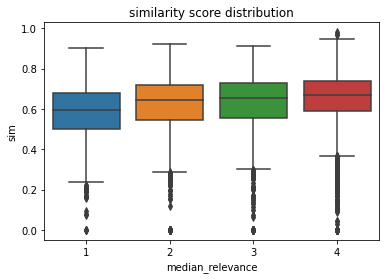

In [18]:
sns.boxplot(x='median_relevance', y='sim', data=expo)
plt.title('similarity score distribution')
plt.show()

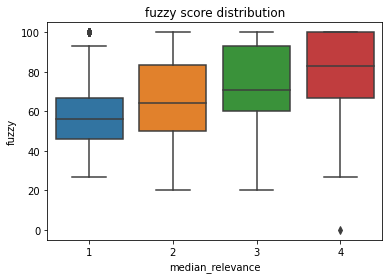

In [19]:
sns.boxplot(x='median_relevance', y='fuzzy', data=expo)
plt.title('fuzzy score distribution')
plt.show()

**Observation** : positive correlation between fuzzywuzzy/similarity scores with median_relevance values.

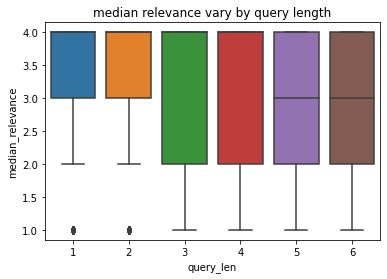

In [20]:
sns.boxplot(x='query_len', y='median_relevance', data=expo)
plt.title('median relevance vary by query length')
plt.show()

In [21]:
expo.groupby(['query_len']).agg({'median_relevance': 'mean'})

,median_relevance
query_len,
1,3.340113
2,3.414203
3,3.152536
4,3.221622
5,2.855072
6,2.913580


**Observations**: Longer search queries have lower median_relevance score on average.

In [22]:
expo['median_relevance'].value_counts(normalize=True)

4    0.607501
3    0.170998
2    0.145304
1    0.076196
Name: median_relevance, dtype: float64

**Observations**: target variable is imbalance, with 60% of the rating being 4. We will need to modify the machine learning algorithm to account for this.

In [23]:
# create separate list based on median_relevance. This is to preserve words that have particular strength on predicting rating 1-4

med_rel_1 = expo.query('median_relevance == 1')['query'].to_list()
med_rel_2 = expo.query('median_relevance == 2')['query'].to_list()
med_rel_3 = expo.query('median_relevance == 3')['query'].to_list()
med_rel_4 = expo.query('median_relevance == 4')['query'].to_list()

### Generate Word features

Apply Tfdif to get obtain words that are perceived to be important based on its appearance frequency.

In [24]:
vect_1 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))
vect_1.fit_transform(med_rel_1)
X_1 = vect_1.get_feature_names()

vect_2 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))
vect_2.fit_transform(med_rel_2)
X_2 = vect_2.get_feature_names()

vect_3 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))
vect_3.fit_transform(med_rel_3)
X_3 = vect_3.get_feature_names()

vect_4 = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))
vect_4.fit_transform(med_rel_4)
X_4 = vect_4.get_feature_names()

In [25]:
# remvoe duplicates on words appear in multiple lists

tup_list = list(set(X_1 + X_2 + X_3 + X_4))

In [26]:
# Store the list in a pickle file to used for tranforming test set later.

with open('data/tup_list.pkl', 'wb') as f:
    pickle.dump(tup_list, f)

In [27]:
# add key words as binary variable to the dataframe.

for term in tup_list:
    expo[term] = expo['query'].str.contains(term)

In [28]:
expo.set_index('id').to_csv('./data/df_clean.csv')